In [7]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/23596
# 标题：玩趋势交易的看进来-2

import pandas as pd
import matplotlib.pyplot as plt
import datetime
date=datetime.datetime.now()

In [4]:
#可调节参数

A = 8 #均线

M = 0.04 #阀门  

K = 0.001 #漂移函数 drift=time* K       

C = 0.06#大波保护

D = C*0.9 #大波保护提升

E = 250 #长线保护

In [5]:
def ma_math(stock_data,A):
    return pd.Series.rolling(stock_data,window=A).mean()

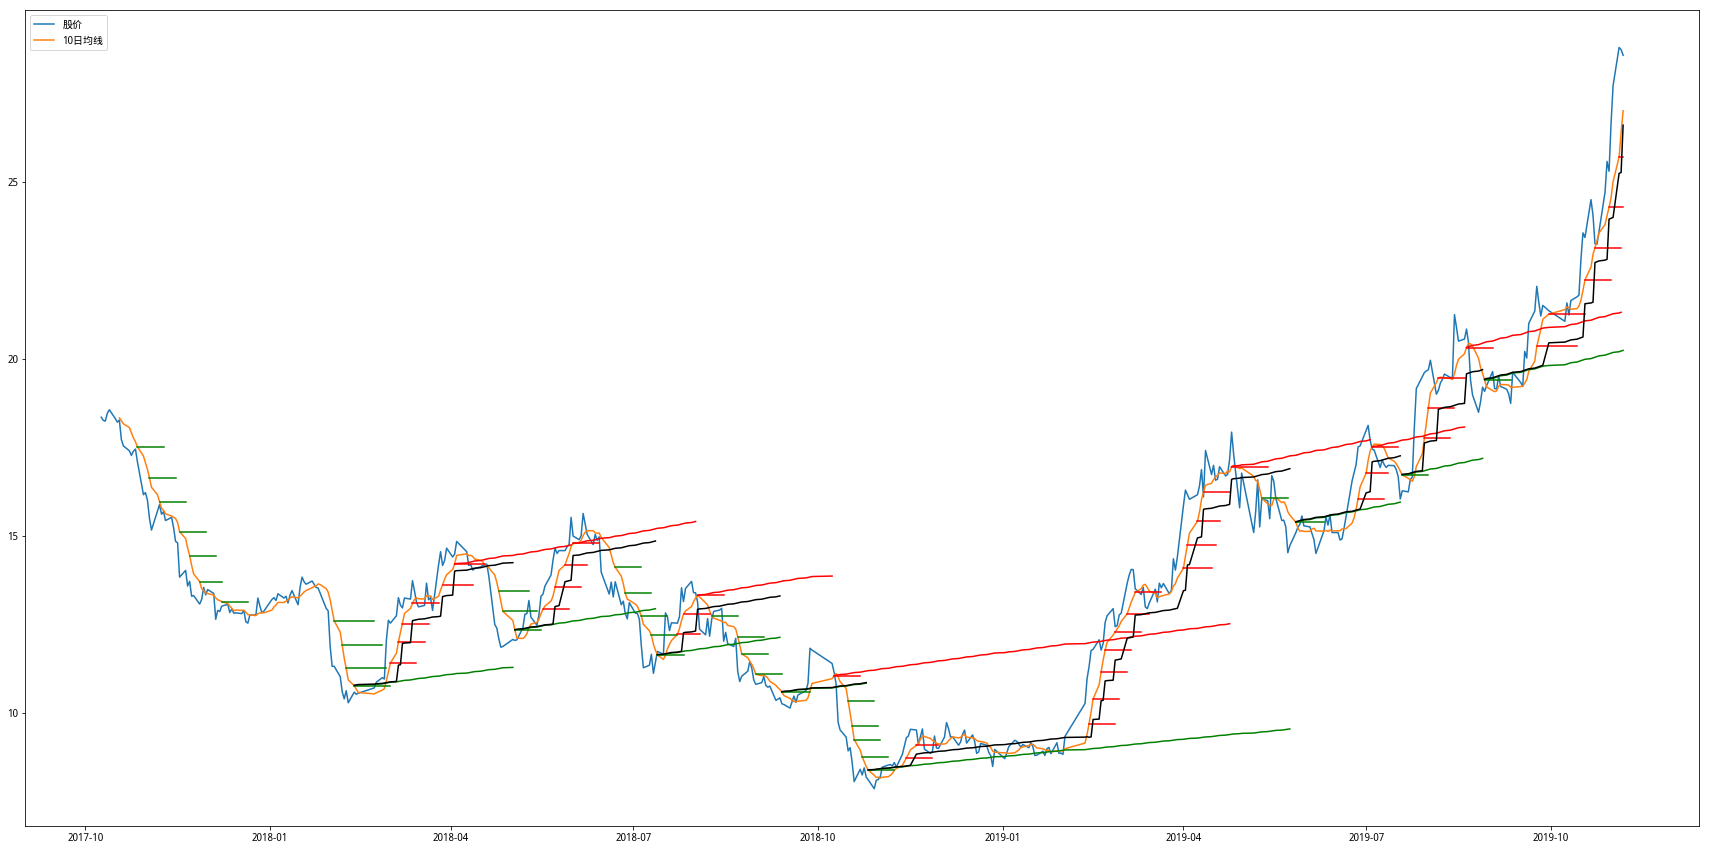

In [9]:
#参数
N = 500 #以过去N天为历史
stock = '002568.XSHE' #股票代码

stock_data = get_price(stock,count = N + A, end_date=date,fields = ['close'])['close']
ma = ma_math(stock_data,A)

plt.figure(figsize=[30,15])
plt.plot(stock_data,label='股价')
plt.plot(ma,label='10日均线')

#if len(stock_data) > 250:
#    ma250 = ma_math(stock_data,250)
#    plt.plot(ma250,label='250日均线')


#设置极值, 极值点Extreme Point(ep)
K_EPs = pd.DataFrame(columns=['date','trend','ep','lineno','groupno']) # 极值日期，极值方向(上为1，下为0)，极值数值，在ma中的行号，多空组号(连续出现的多空方向一样的：同一组)
extreme_price = f_max = f_min = ma[A]
_groupno = 0
_last_trend = 2     # 为了不跟1,0相同，随便赋一个值
for i in range(A,len(ma)):
    if ma[i] > ((extreme_price * M) + extreme_price):
        if _last_trend != 1:
            _last_trend = 1
            _groupno += 1       # 方向改变，组号+1
        extreme_price = f_max = ma[i]
        K_EPs = K_EPs.append({'date':ma.index[i],'trend':1, 'ep':extreme_price,'lineno':i,'groupno': _groupno}, ignore_index=True)
    if ma[i] < (extreme_price - (extreme_price * M)):
        if _last_trend != 0:
            _last_trend = 0
            _groupno += 1       # 方向改变，组号+1
        extreme_price = f_min = ma[i]
        K_EPs = K_EPs.append({'date':ma.index[i],'trend':0, 'ep':extreme_price,'lineno':i,'groupno': _groupno}, ignore_index=True)
#
K_EPs.set_index('date',drop=True,inplace=True)

# print("目前值大为：",f_max)
# print("目前值小为：",f_min)

#画极值
fa_number=10 #画图极值的长度
for i in range(len(K_EPs)):
    _lineno = K_EPs['lineno'][i]
    plt.plot(pd.Series(K_EPs['ep'][i] ,index = ma.index[_lineno:_lineno+fa_number]), \
             color='red' if K_EPs['trend'][i] == 1 else 'green')

#画drift波段保护线   
# 连续的同方向的极值点，是同一组，只保留最后一个（因为下降趋势是下降的，上升趋势是上升的，所以，下降时最后一个最小，或者上升时最后一个最大）
transit_points = K_EPs.drop_duplicates(subset=['groupno'], keep='last')     # 同一组只保留最后一条记录
transit_points.reset_index(drop=True,inplace=True) # 重新索引

# 画漂移价格：极值*(1+n*K)
for i in range(len(transit_points)):
    if i < (len(transit_points)-2):
        s_drift = pd.Series(0.000 ,index = ma.index[transit_points['lineno'][i]: transit_points['lineno'][i+2]])    # 从当前日期画到下一次同方向(trend)出现的日期
    else:
        s_drift = pd.Series(0.000 ,index = ma.index[transit_points['lineno'][i]: ])    # 最后两个漂移线因空间不足另作处理
    #
    f_ep = transit_points['ep'][i]
    for j in range(len(s_drift)):
        s_drift[j] = f_ep*(1 + j*K)
    #
    plt.plot(s_drift, color='red' if transit_points['trend'][i]==1 else 'green')
    
#drift大波保护线  两个参数一个是满足条件C，一个是提升项D，C尽可能的取大，D取相对C一半左右，C=40,D=20
# 要用到的数据 10日均线，只有处于下跌的极值数据方向为0，对应数据日期
#规则，每从最低点涨幅超过10%，上调5%
transit_0 = transit_points[transit_points.trend==0].reset_index(drop=True)
for i in range(len(transit_0)):
    if i < (len(transit_0)-1):
        s_protector = pd.Series(0.000, index=ma.index[transit_0['lineno'][i]: transit_0['lineno'][i+1]])   # 一上一下，这一个波段经历的交易日
    else:
        s_protector = pd.Series(0.000, index=ma.index[transit_0['lineno'][i]: ])   # 最后一个0突变点
    #
    midA = midB = transit_0['ep'][i]
    for j in range(len(s_protector)):
        if s_protector.index[j] in K_EPs.index:  # 如果是极值点
            if K_EPs['ep'][s_protector.index[j]] > midB*(1+C):  # ep>保护条件
                midA = midB = midB*(1+D)
            else:
                midA = midA*(1+K)
        else:
            midA = midA*(1+K)
        #
        s_protector[j] = midA
    #
    plt.plot(s_protector, color='black')
#
plt.legend(loc='best')
plt.show()
